In [72]:
import pymongo
import string
import datetime
import re
import numpy as np
from collections import Counter
from bson.json_util import dumps
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from nltk.stem.snowball import SnowballStemmer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as sk

from sklearn.model_selection import train_test_split
%matplotlib inline 
plt.style.use('fivethirtyeight') # a popular data visualization theme

import nltk
from nltk.corpus import stopwords

In [2]:
#Initialize database
client = pymongo.MongoClient('localhost', 27017)
db = client['yelpdb']


In [105]:
biz_df = pd.read_json(dumps(list(db['Italian_Restaurants'].find())))

reviews_df = pd.read_json(dumps(list(db['Italian_Reviews'].find())))
reviews_df = reviews_df[reviews_df.apply(lambda x: 3 != x['stars'], axis=1)]

In [179]:
users_ids = reviews_df.user_id.unique().tolist()
print(users_ids[0])

L8P5OWO1Jh4B2HLa1Fnbng


In [107]:
biz_reviews = biz_df.merge(reviews_df, on='business_id', how='inner')
#biz_reviews = biz_reviews[['business_id','name','stars_y','text']]

biz_reviews['target'] = biz_reviews.apply(lambda x: 1 == x['stars_y'] or 2 == x['stars_y'], axis=1)


In [111]:
biz_reviews.iloc[2]

_id_x                              {'$oid': '5afee7049954de746fcd38ca'}
attributes            {'Alcohol': 'beer_and_wine', 'HasTV': True, 'N...
business_id                                      dPxZI9lrKTl5dvFfnb1_Ig
latitude                                                        36.0101
longitude                                                      -115.119
name                                                   Trattoria Italia
neighborhood                                                     Anthem
review_count                                                        210
stars_x                                                             4.5
Preprocessed_Text     [went, first, time, tonight, within, first, bi...
_id_y                              {'$oid': '5afee7049954de746fcd38cb'}
cool                                                                  1
date                                                2016-12-13 00:00:00
funny                                                           

In [113]:
# Create a class-balanced subsample
negative = biz_reviews[biz_reviews.apply(lambda x: 1 == x['stars_y'] or 2 == x['stars_y'], axis=1)]
positive = biz_reviews[biz_reviews.apply(lambda x: 4 == x['stars_y'] or 5 == x['stars_y'], axis=1)]

count_neg = len(negative.index)
count_pos = len(positive.index)
if(count_neg < count_pos):
    down_sample = count_neg/count_pos
    positive = positive.sample(frac=down_sample, random_state=123)
elif(count_neg > count_pos):
    down_sample = count_pos/count_neg
    negative = negative.sample(frac=down_sample, random_state=123)

    
combined = pd.concat([positive, negative])

In [115]:
# Split into training and test data sets
training_data, test_data = train_test_split(combined, 
                                                   train_size=0.7, 
                                                   random_state=123)

#training_data

/home/someone/PycharmProjects/YelpJupyter/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [117]:
bow_transform = CountVectorizer()
X_tr_bow = bow_transform.fit_transform(training_data['text'])
X_te_bow = bow_transform.transform(test_data['text'])
len(bow_transform.vocabulary_)

31494

In [119]:
y_tr = training_data['target']
y_te = test_data['target']

# Create the tf-idf representation using the bag-of-words matrix
tfidf_trfm = TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_trfm.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_trfm.transform(X_te_bow)

#l2-normalize the bag-of-words representation
X_tr_l2 = sk.normalize(X_tr_bow, axis=0)
X_te_l2 = sk.normalize(X_te_bow, axis=0)

#na valw garbage

In [121]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description):
    ## Helper function to train a logistic classifier and score on test data
    m = LogisticRegression().fit(X_tr, y_tr)
    s = m.score(X_test, y_test)
    print ('Test score with', description, 'features:', s)
    return m

In [123]:
m1 = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
m2 = simple_logistic_classify(X_tr_l2, y_tr, X_te_l2, y_te, 'l2-normalized')
m3 = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test score with bow features: 0.9421797004991681


Test score with l2-normalized features: 0.9277246256239601


Test score with tf-idf features: 0.9387479201331115


In [127]:
m = len(reviews_df.business_id.unique())
from sklearn.feature_extraction import FeatureHasher
h = FeatureHasher(n_features=m, input_type='string')
f = h.transform(reviews_df['business_id'])

Our pandas Series, in bytes:  5700090
Our hashed numpy array, in bytes:  56


In [128]:
reviews_df['business_id'].unique().tolist()[0:5]
['vcNAWiLM4dR7D2nwwJ7nCA',
 'UsFtqoBl7naz8AVUBZMjQQ',
 'cE27W9VPgO88Qxe4ol6y_g',
 'HZdLhv6COCleJMo7nPl-RA',
 'mVHrayjG3uZ_RLHkLj-AMg']

Our pandas Series, in bytes:  5700090
Our hashed numpy array, in bytes:  56


In [130]:
from sys import getsizeof
print('Our pandas Series, in bytes: ', getsizeof(reviews_df['business_id']))
print('Our hashed numpy array, in bytes: ', getsizeof(f))

Our pandas Series, in bytes:  5700090
Our hashed numpy array, in bytes:  56


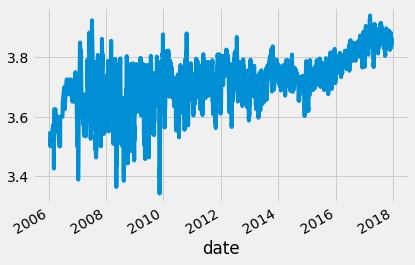

In [136]:
biz_reviews.groupby('date').mean()['stars_x'].rolling(10).mean().plot()

In [145]:
biz_reviews.info()
biz_reviews['target'].value_counts(normalize=True)
# get null accuracy
# 75% positive
# 25% negative

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65518 entries, 0 to 65517
Data columns (total 26 columns):
_id_x                 65518 non-null object
attributes            65518 non-null object
business_id           65518 non-null object
latitude              65518 non-null float64
longitude             65518 non-null float64
name                  65518 non-null object
neighborhood          65518 non-null object
review_count          65518 non-null int64
stars_x               65518 non-null float64
Preprocessed_Text     65518 non-null object
_id_y                 65518 non-null object
cool                  65518 non-null int64
date                  65518 non-null datetime64[ns]
funny                 65518 non-null int64
review_id             65518 non-null object
stars_y               65518 non-null int64
text                  65518 non-null object
useful                65518 non-null int64
user_average_stars    7503 non-null float64
user_cool             7503 non-null float64
user_

False    0.755395
True     0.244605
Name: target, dtype: float64

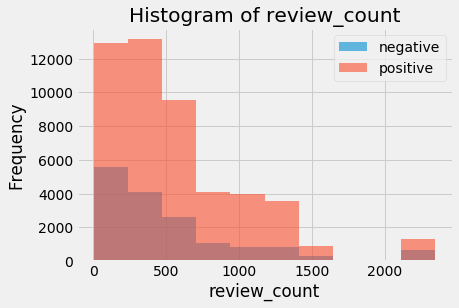

In [ ]:
####  try to visualize some of the differences between positive and negative reviews
biz_reviews.head()

col = 'user_average_stars'
plt.hist(biz_reviews[biz_reviews['target']==True][col], 10, alpha=0.6, label='negative')
plt.hist(biz_reviews[biz_reviews['target']==False][col], 10, alpha=0.6, label='positive')
plt.legend(loc='upper right')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.title('Histogram of {}'.format(col))
plt.show()

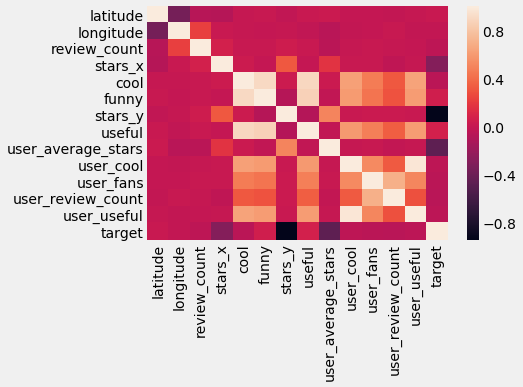

In [155]:
sns.heatmap(biz_reviews.corr())

In [157]:
biz_reviews.corr()['stars_y']
# we keep 'stars_x' and 'user_average_stars' features

latitude             -0.021098
longitude             0.005401
review_count          0.038470
stars_x               0.319219
cool                  0.033059
funny                -0.070777
stars_y               1.000000
useful               -0.079734
user_average_stars    0.506000
user_cool             0.016045
user_fans             0.027454
user_review_count     0.023993
user_useful           0.019171
target               -0.941762
Name: stars_y, dtype: float64

Text(0,0.5,'Occurrence')

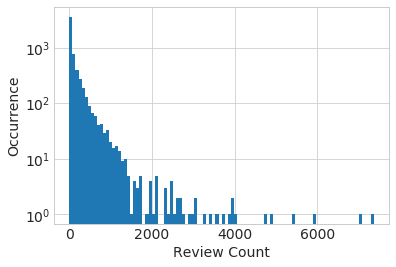

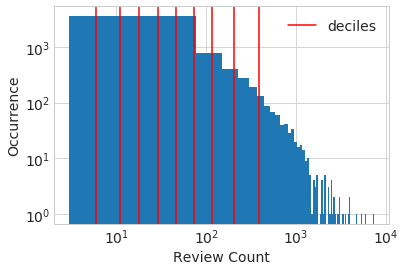

In [8]:
### This plot is showing the histogram of all Italian 
### restaurants review counts. We can see that most of the
### counts are small, but some restaurants have reviews in the thousands.

### Correlation between Popularity(review counts) and Good ratings (star)

biz_df = pd.read_json(dumps(list(db['restaurants'].find())))

sns.set_style('whitegrid')
fig, ax = plt.subplots()
biz_df['review_count'].hist(ax=ax, bins=100)
ax.set_yscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Review Count', fontsize=14)
ax.set_ylabel('Occurrence', fontsize=14)



### Quantitizing the count. We group the counts into bins, and
### get rid of the actual count values. Mapping a continuous number
### to a discrete one.
### Ordered sequence of bins that represent a measure of intensity.
### Deciles divide the data into tenths
### The second plot gives a much clearer picture of the skew toward smaller counts.


deciles = biz_df['review_count'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])
sns.set_style('whitegrid')
fig, ax = plt.subplots()
biz_df['review_count'].hist(ax=ax, bins=100)
for pos in deciles:
    handle = plt.axvline(pos, color='r')
ax.legend([handle], ['deciles'], fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Review Count', fontsize=14)
ax.set_ylabel('Occurrence', fontsize=14)


In [16]:
users = pd.read_json(dumps(list(db['users'].find().limit(100000))))

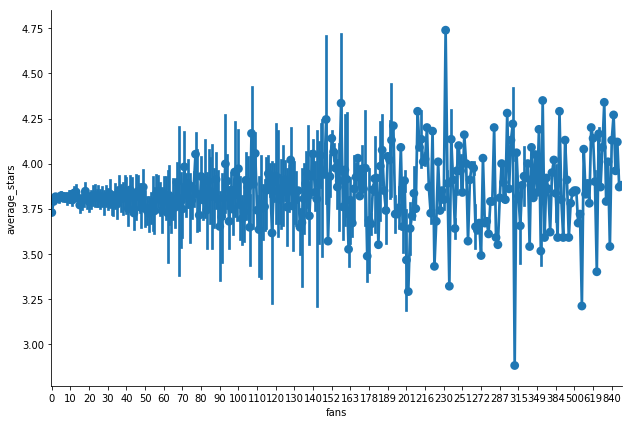

In [20]:
#sns.boxplot(x='fans', y='average_stars', data=users)

g = sns.factorplot(x="fans", y='average_stars', data=users,
                   aspect=1.5, size=6)
g.set_xticklabels(step=10)

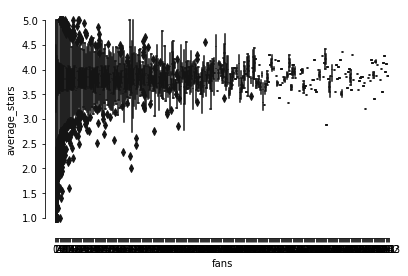

In [21]:
sns.boxplot(x="fans", y="average_stars", data=users, palette="PRGn")
sns.despine(offset=10, trim=True)

In [22]:
italian_reviews = pd.read_json(dumps(list(db['Italian_Reviews'].find())))
italian_restaurants = pd.read_json(dumps(list(db['Italian_Restaurants'].find())))


merge_reviews_restaurants = pd.merge(italian_reviews, italian_restaurants, on='business_id', how='inner')

In [30]:
yelp_reviews = italian_reviews[(italian_reviews['stars'] == 1) | (italian_reviews['stars'] == 5)]

#sentiment = []
#for i in yelp_reviews['stars']:
#    if (i == 1):
#        sentiment.append('BAD')
#    else:
#        sentiment.append('GOOD')

#yelp_reviews['sentiment'] = sentiment

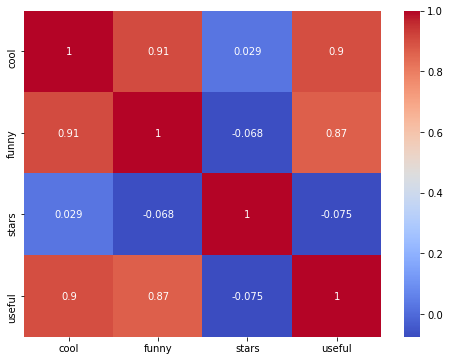

In [33]:



plt.figure(figsize = (8,6))
sns.heatmap(italian_reviews.corr(), cmap = "coolwarm", annot=True)

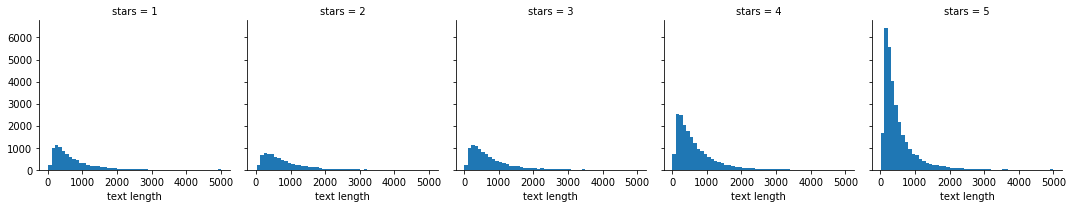

In [33]:
g = sns.FacetGrid(data=italian_reviews, col='stars')
g.map(plt.hist, 'text length', bins=50)

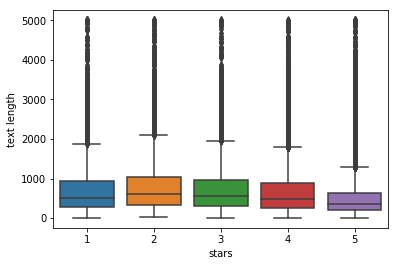

In [34]:
sns.boxplot(x='stars', y='text length', data=italian_reviews)

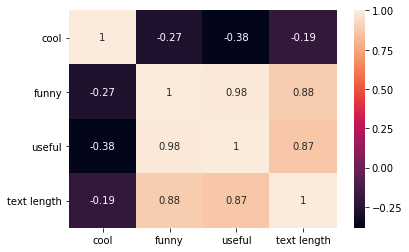

In [36]:
stars = italian_reviews.groupby('stars').mean()
sns.heatmap(data=stars.corr(), annot=True)